# Lab 2

In [1]:
import numpy as np
import scipy.stats as stats
import scipy.optimize as opt
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

## Task 1

In [2]:
def gen_norm(p, size):
    return np.random.multivariate_normal([0, 0], [[1, p], [p, 1]], size).T

In [3]:
def gen_mix(size):
    return 0.9 * np.random.multivariate_normal([0, 0], [[1, 0.9], [0.9, 1]], size).T +\
                    0.1 * np.random.multivariate_normal([0, 0], [[10, 9], [9, 10]], size).T

### Coefficients

In [4]:
def rq(x, y):
    med_x = np.median(x)
    med_y = np.median(y)
    n1 = np.array([x >= med_x and y >= med_y for x, y in zip(x, y)]).sum()
    n2 = np.array([x < med_x and y >= med_y for x, y in zip(x, y)]).sum()
    n3 = np.array([x < med_x and y < med_y for x, y in zip(x, y)]).sum()
    n4 = np.array([x >= med_x and y < med_y for x, y in zip(x, y)]).sum()
    return ((n1 + n3) - (n2 + n4)) / len(x)

In [17]:
tables = []
param_signs = ['$E(z)$', '$E(z^2)$', '$D(z)$']
for size in [20, 60, 100]:
    table = []
    for p in [0, 0.5, 0.9]:
        table.append(['$\\rho = ' + str(p) + '~(\\ref{ro})$', '$r ~(\\ref{r})$',
          '$r_Q ~(\\ref{rQ})$', '$r_S ~(\\ref{rS})$'])
        for param_sign, param_calc_f in zip(param_signs, [np.mean, lambda vals: np.mean(np.array(vals) ** 2), np.std]):
            row = []
            row.append(param_sign) 
            for coef_calc_f in [lambda x, y: stats.pearsonr(x, y)[0], lambda x, y: stats.spearmanr(x, y)[0], rq]:
                row.append(round(param_calc_f([coef_calc_f(*gen_norm(p, size)) for i in range(1000)]), 3))
            table.append(row)
    tables.append(table)

In [11]:
mix_table = []
param_signs = ['$E(z)$', '$E(z^2)$', '$D(z)$']
for size in [20, 60, 100]:
    mix_table.append(['$n$ = ' + str(size), '$r ~(\\ref{r})$', '$r_Q ~(\\ref{rQ})$', '$r_S ~(\\ref{rS})$'])
    for param_sign, param_calc_f in zip(param_signs, [np.mean, lambda vals: np.mean(np.array(vals) ** 2), np.std]):
        row = []
        row.append(param_sign) 
        for coef_calc_f in [lambda x, y: stats.pearsonr(x, y)[0], lambda x, y: stats.spearmanr(x, y)[0], rq]:
            row.append(round(param_calc_f([coef_calc_f(*gen_mix(size)) for i in range(1000)]), 3))
        mix_table.append(row)

In [142]:
for size, table in zip([20, 60, 100], tables):
    with open("task1_data/" + str(size) + ".tex", "w") as f:
        f.write("\\begin{tabular}{|c|c|c|c|}\n")
        f.write("\\hline\n")
        for row in table:
            f.write(" & ".join([str(i) for i in row]) + "\\\\\n")
            f.write("\\hline\n")
        f.write("\\end{tabular}")

In [12]:
with open("task1_data/mix.tex", "w") as f:
        f.write("\\begin{tabular}{|c|c|c|c|}\n")
        f.write("\\hline\n")
        for row in mix_table:
            f.write(" & ".join([str(i) for i in row]) + "\\\\\n")
            f.write("\\hline\n")
        f.write("\\end{tabular}")

### Ellipses

In [38]:
def confidence_ellipse(x, y, ax, n_std=3.0):
    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
   
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor='none', edgecolor='navy')

    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

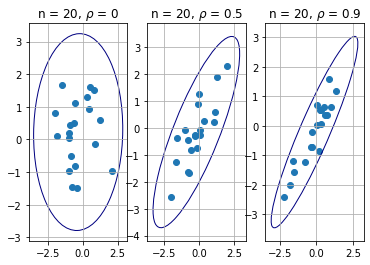

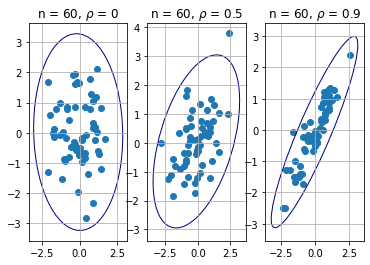

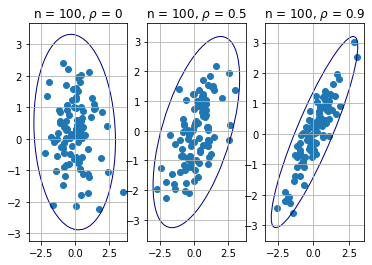

In [46]:
for n in [20, 60, 100]:
    fig, ax = plt.subplots(1, 3)
    for i, p in enumerate([0, 0.5, 0.9]):
        x, y = gen_norm(p, n)
        ax[i].scatter(x, y)
        confidence_ellipse(x, y, ax[i])
        ax[i].grid()
        ax[i].set_title(fr'n = {n}, $\rho$ = {p}')

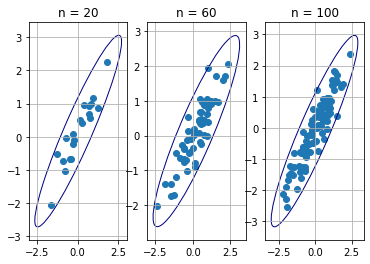

In [50]:
fig, ax = plt.subplots(1, 3)
for i, n in enumerate([20, 60, 100]):
    x, y = gen_mix(n)
    ax[i].scatter(x, y)
    confidence_ellipse(x, y, ax[i])
    ax[i].grid()
    ax[i].set_title(f'n = {n}')

## Task 2

In [113]:
class LinearModel:
    def __init__(self):
        self.b0 = 0
        self.b1 = 0
        
    def predict(self, x):
        return self.b0 + self.b1 * x

class LSM(LinearModel):
    def fit(self, x, y):
        xy_m = np.mean(x * y)
        x_m = np.mean(x)
        x_2_m = np.mean(x ** 2)
        y_m = np.mean(y)
        self.b1 = (xy_m - x_m * y_m) / (x_2_m - x_m * x_m)
        self.b0 = y_m - x_m * self.b1

class LAD(LinearModel):
    def fit(self, x, y):
        def abs_error(b, *data):
            x, y = data
            y_predict = b[0] + b[1] * x
            return np.linalg.norm(y - y_predict, ord=1)
            
        self.b0, self.b1 = opt.minimize(abs_error, [0, 1], args=(x, y)).x

In [114]:
def original(x):
    return 2 * x + 2

### Without noise

LSM: b0 = 2.092161016414424, b1 = 2.0113162607951156
LAD: b0 = 2.0642812831366033, b1 = 2.2342326760351097


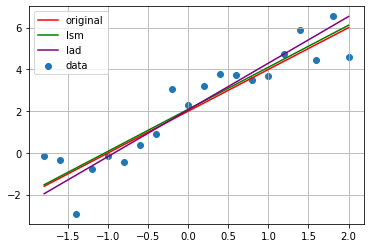

In [118]:
x = np.arange(-1.8, 2.2, 0.2)
y = original(x) + np.random.standard_normal(len(x))

lsm = LSM()
lsm.fit(x, y)
print(f'LSM: b0 = {lsm.b0}, b1 = {lsm.b1}')

lad = LAD()
lad.fit(x, y)
print(f'LAD: b0 = {lad.b0}, b1 = {lad.b1}')

fig, ax = plt.subplots()
ax.scatter(x, y, label='data')
points = np.linspace(-1.8, 2, 100)
ax.plot(points, func(points), color='red', label='original')
ax.plot(points, lsm.predict(points), color='green', label='lsm')
ax.plot(points, lad.predict(points), color='purple', label='lad')
ax.legend()
ax.grid()

### With noise

b0 = 2.1172976596400996, b1 = 0.4440181567862329
LAD: b0 = 2.145598534008495, b1 = 1.9357562453837098


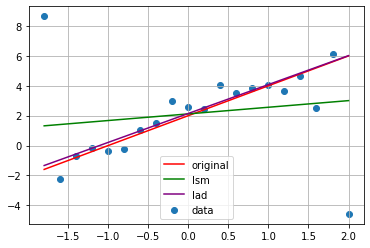

In [119]:
x = np.arange(-1.8, 2.2, 0.2)
y = original(x) + np.random.standard_normal(len(x))
y[0] += 10
y[19] -= 10

lsm = LSM()
lsm.fit(x, y)
print(f'b0 = {lsm.b0}, b1 = {lsm.b1}')

lad = LAD()
lad.fit(x, y)
print(f'LAD: b0 = {lad.b0}, b1 = {lad.b1}')

fig, ax = plt.subplots()
ax.scatter(x, y, label='data')
points = np.linspace(-1.8, 2, 100)
ax.plot(points, func(points), color='red', label='original')
ax.plot(points, lsm.predict(points), color='green', label='lsm')
ax.plot(points, lad.predict(points), color='purple', label='lad')
ax.legend()
ax.grid()

## Task 3

In [131]:
data = np.random.standard_normal(100)

In [34]:
def chi_table(data):
    mu = np.mean(data)
    sigma = np.std(data)
    print(f'mu={mu}, sigma={sigma}')

    k = int(np.floor(1.72 * len(data)**(1/3)))
    borders = np.linspace(np.floor(np.min(data)), np.ceil(np.max(data)), k-1)
    borders = np.insert(borders, 0, -np.inf)
    borders = np.append(borders, np.inf)
    
    table = []
    table.append(['\hline i', 'Границы $\Delta_i$', '$n_i$', '$p_i$', 
                  '$np_i$', '$n_i - np_i$', '$\\frac{(n_i - np_i)^2}{np_i}$'])
    
    ns = []
    ps = []
    nps = []
    n_sub_nps = []
    ress = []
   
    for i in range(len(borders) - 1):
        left = borders[i]
        right = borders[i + 1]
        
        n = ((left < data) & (data <= right)).sum()
        ns.append(n)
        
        p = stats.norm.cdf(right) - stats.norm.cdf(left)
        ps.append(p)
        
        np_ =  len(data) * p
        nps.append(np_)
        
        n_sub_np = n - np_
        n_sub_nps.append(n_sub_np)
        
        res = n_sub_np ** 2 / np_
        ress.append(res)
        
        table.append([i + 1, f'({round(left, 2)}, {round(right, 2)}]', 
                      round(n, 2), round(p, 2), round(np_, 2), round(n_sub_np, 2), round(res, 2)])
    table.append(['$\sum$', '-', sum(ns), sum(ps), round(sum(nps)), round(sum(n_sub_nps)), round(sum(ress), 2)])
    return table

In [35]:
def write_table(path, table):
    with open(path, "w") as f:
        f.write("\\begin{tabular}{|c|c|c|c|c|c|c|}\n")
        f.write("\\hline\n")
        for row in table:
            f.write(" & ".join([str(i) for i in row]) + "\\\\\n")
            f.write("\\hline\n")
        f.write("\\end{tabular}")

In [36]:
write_table('task3_normal.tex', chi_table(np.random.standard_normal(100)))
write_table('task3_laplace.tex', chi_table(np.random.laplace(0, 1 / np.sqrt(2), 20)))

mu=0.020286301225180756, sigma=0.8625921589843055
mu=-0.17654405503758547, sigma=1.1906636424789219


## Task 4

In [7]:
def ci_mean_t(data, alpha):
    n = len(data)
    m = np.mean(data)
    s = np.std(data)
    t = stats.t.ppf(1 - alpha / 2, n - 1)
    d = s * t / np.sqrt(n - 1)
    return m - d, m + d

In [21]:
def ci_std_t(data, alpha):
    n = len(data)
    s = np.std(data)
    return s * np.sqrt(n) / np.sqrt(stats.chi2.ppf(1 - alpha / 2, n - 1)), s * np.sqrt(n) / np.sqrt(stats.chi2.ppf(alpha / 2, n - 1))

In [22]:
def ci_mean_asymp(data, alpha):
    n = len(data)
    m = np.mean(data)
    s = np.std(data)
    u = stats.norm.ppf(1 - alpha / 2)
    d = s * u / np.sqrt(n)
    return m - d, m + d

In [23]:
def ci_std_asymp(data, alpha):
    n = len(data)
    s = np.std(data)
    u = stats.norm.ppf(1 - alpha / 2)
    m4 = stats.moment(data, 4)
    e = m4 / s ** 4 - 3
    U = u * np.sqrt((e + 2) / n)
    return s / np.sqrt(1 + U), s / np.sqrt(1 - U)

In [36]:
data20 = np.random.standard_normal(20)
data100 = np.random.standard_normal(100)

In [41]:
t_mean_20 = ci_mean_t(data20, 0.05)
t_mean_100 = ci_mean_t(data100, 0.05)
t_std_20 = ci_std_t(data20, 0.05)
t_std_100 = ci_std_t(data100, 0.05)

asymp_mean_20 = ci_mean_asymp(data20, 0.05)
asymp_mean_100 = ci_mean_asymp(data100, 0.05)
asymp_std_20 = ci_mean_asymp(data20, 0.05)
asymp_std_100 = ci_mean_asymp(data100, 0.05)

In [43]:
print(t_mean_20, t_std_20)
print(t_mean_100, t_std_100)
print(asymp_mean_20, asymp_std_20)
print(asymp_mean_100, asymp_std_100)

(-0.39326250785957967, 0.29654488411612684) (0.5604441747297365, 1.0763697626447994)
(-0.23721653162178852, 0.20054678515818825) (0.968541238666665, 1.2814597022577)
(-0.36315794110919436, 0.26644031736574153) (-0.36315794110919436, 0.26644031736574153)
(-0.23345740641863685, 0.19678765995503658) (-0.23345740641863685, 0.19678765995503658)


Text(0.5, 1.0, 'N(0,1) hist, n = 100')

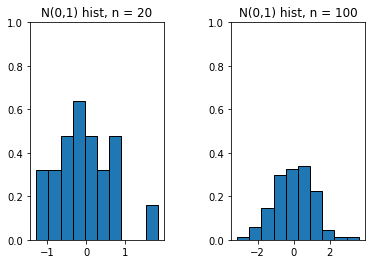

In [40]:
fig, ax = plt.subplots(1, 2)
plt.subplots_adjust(wspace = 0.5)
ax[0].set_ylim([0,1])
ax[0].hist(data1, 10, density = 1, edgecolor = 'black')
ax[0].set_title('N(0,1) hist, n = 20')
ax[1].set_ylim([0,1])
ax[1].hist(data2, 10, density = 1, edgecolor = 'black')
ax[1].set_title('N(0,1) hist, n = 100')

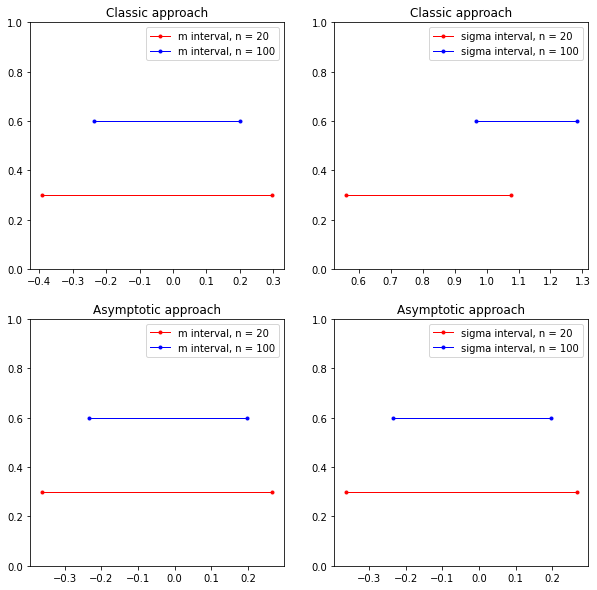

In [60]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
plt.subplots_adjust(wspace = 0.2, hspace = 0.2) 

ax[0][0].plot([q for q in t_mean_20], [0.3, 0.3], color='r', marker = '.', linewidth = 1, label = 'm interval, n = 20')
ax[0][0].plot([q for q in t_mean_100], [0.6, 0.6], color='blue', marker = '.', linewidth = 1, label = 'm interval, n = 100')
ax[0][0].set_ylim([0,1])
ax[0][0].set_title('Classic approach')
ax[0][0].legend()

ax[0][1].plot([q for q in t_std_20], [0.3, 0.3], color='r', marker = '.', linewidth = 1, label = 'sigma interval, n = 20')
ax[0][1].plot([q for q in t_std_100], [0.6, 0.6], color='blue', marker = '.', linewidth = 1, label = 'sigma interval, n = 100')
ax[0][1].set_ylim([0,1])
ax[0][1].set_title('Classic approach')
ax[0][1].legend()

ax[1][0].plot([q for q in asymp_mean_20], [0.3, 0.3], color='r', marker = '.', linewidth = 1, label = 'm interval, n = 20')
ax[1][0].plot([q for q in asymp_mean_100], [0.6, 0.6], color='blue', marker = '.', linewidth = 1, label = 'm interval, n = 100')
ax[1][0].set_ylim([0,1])
ax[1][0].set_title('Asymptotic approach')
ax[1][0].legend()

ax[1][1].plot([q for q in asymp_std_20], [0.3, 0.3], color='r', marker = '.', linewidth = 1, label = 'sigma interval, n = 20')
ax[1][1].plot([q for q in asymp_std_100], [0.6, 0.6], color='blue', marker = '.', linewidth = 1, label = 'sigma interval, n = 100')
ax[1][1].set_ylim([0,1])
ax[1][1].set_title('Asymptotic approach')
ax[1][1].legend()